<a href="https://colab.research.google.com/github/shearere2/fall_2024_transit/blob/main/FallTransitExperimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install momepy
import momepy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.3/347.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 51.5 MB/s eta 0:00:00


In [3]:
gdf = gpd.read_file('AlleghenyCounty_StreetCenterlines202408.zip')
gdf.crs

<Projected CRS: EPSG:2272>
Name: NAD83 / Pennsylvania South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Pennsylvania - counties of Adams; Allegheny; Armstrong; Beaver; Bedford; Berks; Blair; Bucks; Butler; Cambria; Chester; Cumberland; Dauphin; Delaware; Fayette; Franklin; Fulton; Greene; Huntingdon; Indiana; Juniata; Lancaster; Lawrence; Lebanon; Lehigh; Mifflin; Montgomery; Northampton; Perry; Philadelphia; Schuylkill; Snyder; Somerset; Washington; Westmoreland; York.
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
gdf = gdf.to_crs(4326)

In [5]:
original = gdf.copy()

In [6]:
infrastructure = original.copy()

In [7]:
infrastructure = infrastructure.to_crs(4326)

In [9]:
# Graph for infrastructure layer of bi-layer transport network
# Note: Contains busways, does not contain light rail
infra_layer = momepy.gdf_to_nx(infrastructure)

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [10]:
count = 0
for i in infra_layer.nodes():
  print(i[1], i[0])
  count += 1
  if count == 20: break

40.61005295198786 -79.74825488779163
40.61108489035708 -79.747095261925
40.609609462246674 -79.7487077846762
40.60937834098814 -79.74893509132836
40.60904657776651 -79.74946562738229
40.60843936963824 -79.75046458047557
40.60874921985767 -79.74995124754275
40.613255856439636 -79.72998504023654
40.61356154279988 -79.72868530622699
40.61289022857872 -79.73153789455564
40.612471286062785 -79.7333170369017
40.612264255235935 -79.73418370517119
40.61188541968434 -79.7357829610975
40.52118448084461 -80.02391568998324
40.52206145843534 -80.02204542369785
40.40483323824357 -79.91063980763381
40.40574498064666 -79.9094585198031
40.406469277385256 -79.90805838367679
40.40737587246903 -79.90626892329534
40.407556340632894 -79.90093427958881


<Axes: >

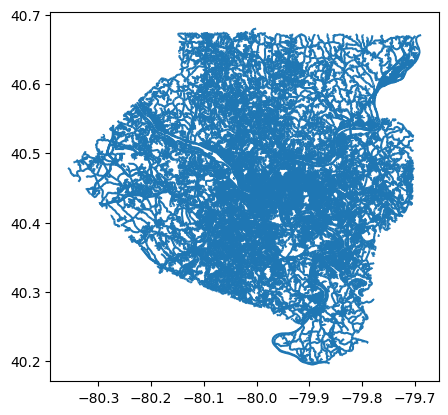

In [11]:
infrastructure['geometry'].plot()

In [16]:
G = infra_layer.copy()

In [17]:
import networkx as nx
mapping = {}
for i in G.nodes():
  if len(infra_layer[i]) == 1:
    print(f"Removing {i}")
    infra_layer.remove_node(i)
  else:
    indexes = []
    for j in infra_layer[i]:
      indexes.append(j)
    streets = []
    for index in indexes:
      streets.append(infra_layer[i][index][0]['FULL_NAME'])
      zip = infra_layer[i][index][0]['R_ZIP']
    streets = list(set(streets))
    if len(streets) < 2:
      print(f"Removing {i} (False node, represents intersection of arbitrary street x with itself)")
      infra_layer.remove_node(i)
    else:
      print("Renaming " + str(i) + " to " + streets[0] + " and " + streets[1] + " - " + str(zip))
      mapping[i] = f'{streets[0]} and {streets[1]}'
infra_layer = nx.relabel_nodes(infra_layer, mapping)

Streaming output truncated to the last 5000 lines.
Removing (-79.90919004454656, 40.45407478073936) (False node, represents intersection of arbitrary street x with itself)
Removing (-79.89723631756647, 40.45019128336315)
Removing (-79.90899350932949, 40.45400818633736) (False node, represents intersection of arbitrary street x with itself)
Removing (-79.97367817812963, 40.5801098739724)
Removing (-79.97058668918204, 40.5800888832296) (False node, represents intersection of arbitrary street x with itself)
Removing (-79.78323380838359, 40.32090961467576)
Removing (-79.78262368911454, 40.321072692746746) (False node, represents intersection of arbitrary street x with itself)
Removing (-79.82583165391866, 40.4298024159111)
Renaming (-80.08948741461435, 40.41456458045258) to THOMAS ST and WILCOX ST - 15106
Removing (-80.08811528349486, 40.41534887784295)
Removing (-80.10174438652078, 40.37162718860439)
Removing (-80.06711415308698, 40.44083500201514)
Renaming (-79.76690037895082, 40.4310266

In [18]:
edges = momepy.nx_to_gdf(infra_layer, points=False)

<Axes: >

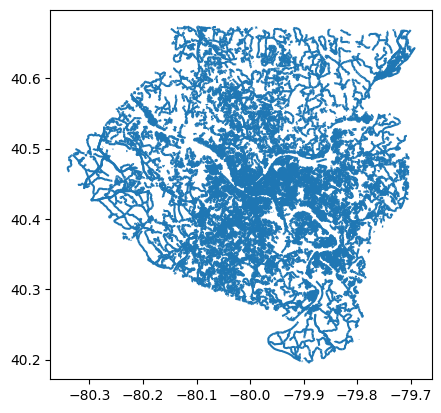

In [20]:
edges['geometry'].plot() # Bad, try OSMNX ?

In [24]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.2 MB/s eta 0:00:00


In [29]:
import osmnx as ox

In [56]:
infra_layer = ox.graph_from_place('Allegheny County, PA', network_type='drive', custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|busway"]')

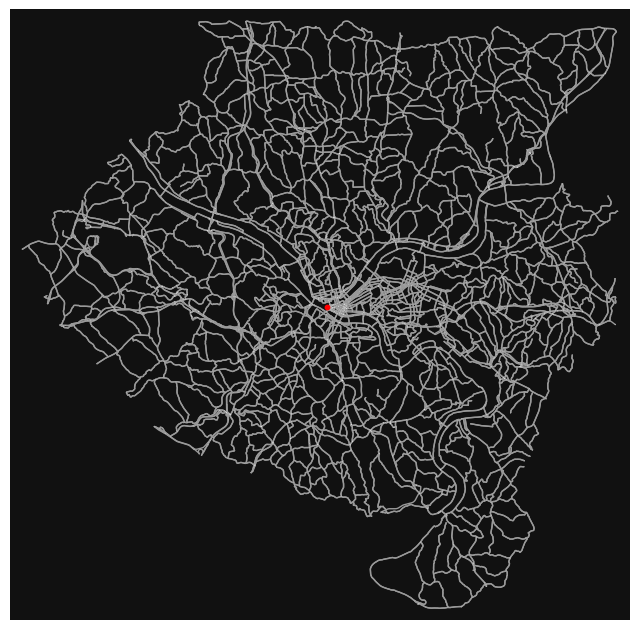

In [57]:
fig, ax = ox.plot_graph(infra_layer, node_size=.1, show=False, close=False)
ax.scatter(-80.01194, 40.44167, c='red', s=10)
plt.show()
# Infrastructure layer complete for busses.
# Need to find out how to add residential hotspots and commercial hotspots

In [102]:
count = 0
target = []
for i in infra_layer.nodes():
  for j in infra_layer[i]:
    print(count)
    try:
      x = infra_layer[i][j][0]['name']
    except:
      print(f'NO NAME? {infra_layer[i]}')
    if x == 'Forbes Avenue':
      target.append(i)
    count += 1

Streaming output truncated to the last 5000 lines.
7273
7274
7275
NO NAME? {740844649: {0: {'osmid': 643222646, 'oneway': True, 'lanes': '2', 'ref': 'PA 910;Yellow Belt', 'name': 'Indianola Road', 'highway': 'primary', 'reversed': False, 'length': 108.361, 'geometry': <LINESTRING (-79.841 40.54, -79.84 40.54, -79.84 40.539, -79.84 40.539, -79....>}}, 740857687: {0: {'osmid': 1224693572, 'oneway': True, 'lanes': '1', 'highway': 'motorway_link', 'reversed': False, 'length': 14.855, 'geometry': <LINESTRING (-79.841 40.54, -79.84 40.54, -79.84 40.54, -79.84 40.54)>}}}
7276
NO NAME? {740857700: {0: {'osmid': 643222643, 'oneway': True, 'lanes': '2', 'highway': 'motorway_link', 'reversed': False, 'length': 63.352, 'geometry': <LINESTRING (-79.84 40.539, -79.84 40.54, -79.84 40.54, -79.84 40.54, -79.84...>}}, 740857687: {0: {'osmid': 1224693573, 'oneway': True, 'lanes': '2', 'ref': 'PA 910;Yellow Belt', 'name': 'Indianola Road', 'highway': 'primary', 'reversed': False, 'length': 51.165, 'geome

In [103]:
for i in target:
  print(infra_layer[i])

{684791935: {0: {'osmid': [1113240062, 11729070], 'name': 'Forbes Avenue', 'highway': 'primary', 'oneway': False, 'reversed': False, 'length': 187.32, 'geometry': <LINESTRING (-79.994 40.438, -79.994 40.438, -79.993 40.438, -79.992 40.438,...>}}, 1364118592: {0: {'osmid': 108295615, 'oneway': False, 'lanes': '4', 'name': 'Crosstown Boulevard', 'highway': 'primary', 'reversed': True, 'length': 223.955, 'geometry': <LINESTRING (-79.994 40.438, -79.994 40.438, -79.994 40.438, -79.994 40.438,...>}}, 684792169: {0: {'osmid': 294921124, 'lanes': '4', 'name': 'Forbes Avenue', 'highway': 'primary', 'oneway': False, 'reversed': True, 'length': 83.43299999999999, 'geometry': <LINESTRING (-79.994 40.438, -79.995 40.438, -79.995 40.438, -79.995 40.438)>}}, 104573452: {0: {'osmid': [302179625, 11689818], 'lanes': '4', 'name': 'Sixth Avenue', 'highway': 'secondary', 'oneway': False, 'reversed': True, 'length': 31.63, 'geometry': <LINESTRING (-79.994 40.438, -79.994 40.438, -79.994 40.438, -79.994 40

In [ ]:
# Create residential and commercial hotspots where routes must lead to

Building Service Graph Layer

In [ ]:
stops = gpd.read_file('paac_stops_1909.zip')

In [ ]:
routes = gpd.read_file('paac_routes_1909 (1).zip')

In [ ]:
stops = stops.to_crs(4326)

In [ ]:
routes

In [ ]:
!pip install momepy

In [ ]:
stops['Routes_ser']

In [ ]:
import momepy
G = momepy.gdf_to_nx(stops)

/usr/local/lib/python3.10/dist-packages/momepy/utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
<ipython-input-37-12e65a5e811c>:2: RuntimeWarning: The given network does not contain any LineString. This can lead to unexpected behaviour. The intended usage of the conversion function is with networks made of LineStrings only.
  G = momepy.gdf_to_nx(stops)


In [ ]:
infra_layer.nodes()

NodeView(((-79.97817, 40.45463499999998), (-79.974651, 40.456287999999965), (-79.96943600000002, 40.46034699999997), (-79.96211500000001, 40.46865499999996), (-79.960929, 40.46767599999997), (-79.961076, 40.467584999999985), (-79.867215, 40.40824199999999), (-79.934107, 40.44852899999996), (-79.938742, 40.44775099999998), (-79.915595, 40.45347999999996), (-79.951806, 40.446703999999976), (-79.952021, 40.44629599999996), (-79.932476, 40.449027999999984), (-79.954707, 40.44461799999996), (-79.95484, 40.44429899999998), (-79.973041, 40.43768999999997), (-79.968584, 40.43647899999997), (-79.961689, 40.43952499999996), (-79.925679, 40.451316999999975), (-79.964185, 40.43769799999997), (-79.948856, 40.44707799999996), (-79.949505, 40.446794999999966), (-79.957877, 40.44232599999998), (-79.980575, 40.43839899999996), (-79.959848, 40.440633999999974), (-79.962128, 40.43895499999997), (-79.909041, 40.45743499999998), (-79.923883, 40.45199599999998), (-79.973003, 40.437894999999976), (-79.988102

In [ ]:
routes

,ROUTE,WeekendSer,Route_Name,Timetable_,Mode,TypeServ,Shape_Leng,Garage,Rt_len_mil,AvgWkdy_CY,AvgSat_CY1,AvgSun_CY1,Tot_riderC,geometry
0,26,Saturday and Sunday,Chartiers,http://www.portauthority.org/PAAC/apps/pdfs/26...,Bus,Local,12.814760,Collier,12.8148,991.0,550.0,352.0,303697.0,"LINESTRING (1341166.750 411957.500, 1341145.50..."
1,27,Saturday and Sunday,Fairywood,http://www.portauthority.org/PAAC/apps/pdfs/27...,Bus,Local,16.025868,Collier,16.0259,1135.0,634.0,459.0,350991.0,"LINESTRING (1341166.750 411957.500, 1341145.50..."
2,40,Saturday and Sunday,Mt. Washington,http://www.portauthority.org/PAAC/apps/pdfs/40...,Bus,Local,10.457127,Collier,10.4571,613.0,229.0,165.0,179034.0,"LINESTRING (1344902.500 412884.750, 1344881.75..."
3,61C,Saturday and Sunday,McKeesport - Homestead,http://www.portauthority.org/PAAC/apps/pdfs/61...,Bus,Key Corridor,30.233825,West Mifflin,30.2338,6314.0,4562.0,3374.0,2051738.0,"LINESTRING (1342249.250 411973.750, 1342246.25..."
4,65,None,Squirrel Hill,http://www.portauthority.org/PAAC/apps/pdfs/65...,Bus,Express,11.727452,West Mifflin,11.7275,438.0,0.0,0.0,112975.0,"LINESTRING (1365290.000 405451.000, 1365248.75..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,17,Saturday and Sunday,Shadeland,http://www.portauthority.org/PAAC/apps/pdfs/17...,Bus,Local,13.041969,Ross,13.0420,1352.0,623.0,567.0,412519.0,"LINESTRING (1336800.433 433140.705, 1336800.38..."
98,19L,None,Emsworth Limited,http://www.portauthority.org/PAAC/apps/pdfs/19...,Bus,Express,15.601440,Ross,15.6014,662.0,0.0,0.0,170780.0,"MULTILINESTRING ((1329304.000 430427.750, 1329..."
99,O5,None,Thompson Run Flyer,http://www.portauthority.org/PAAC/apps/pdfs/O5...,Bus,Express,21.266091,Ross,21.2661,120.0,0.0,0.0,30965.0,"MULTILINESTRING ((1339552.000 431885.750, 1339..."
100,P13,None,Mount Royal Flyer,http://www.portauthority.org/PAAC/apps/pdfs/P1...,Bus,Express,21.802916,Ross,21.9878,308.0,0.0,0.0,79546.0,"MULTILINESTRING ((1357079.500 430136.750, 1356..."


In [ ]:
coords = str(stops['geometry'][0]).split('(')[1].split(' ')
coords[1] = coords[1].split(')')[0]
coords

['-79.97817', '40.45463499999998']

In [ ]:
stops['geometry'].apply(lambda x: str(x).split())

In [ ]:
x = []
y = []
for index, row in stops.iterrows():
  coords = str(row['geometry']).split('(')[1].split(' ')
  coords[1] = coords[1].split(')')[0]
  x.append(coords[0])
  y.append(coords[1])
stops['x'] = x
stops['y'] = y